In [6]:
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from qiskit import( ClassicalRegister,
        QuantumRegister,
        QuantumCircuit,
        execute,
        Aer,
        IBMQ,
        transpile)
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import( plot_histogram,
                        plot_state_city,
                        plot_gate_map, 
                        plot_circuit_layout,
                        circuit_drawer)
from qiskit.circuit.library import QFT
from math import (log,ceil)
from scipy.fft import fft, ifft
from scipy.linalg import dft, inv, expm, norm
from scipy.linalg.interpolative import estimate_spectral_norm
from numpy.linalg import matrix_power
#import networkx as nx
mpl.rcParams['figure.figsize'] = 11,8
mpl.rcParams.update({'font.size' : 15})

## 0 - Functions

### 0.1 - Basic

In [7]:
def circulant_adjacency(n,v):
    iv = list(range(0,n))
    av = list(range(0,n-1))
    C = np.zeros([n,n])
    for z in range(n):
        C[z,0] = v[iv[z]]    
    for x in range(1,n):
        av = iv[0:-1]
        iv[0] = iv[-1]
        iv[1::] = av
        for y in range(0,n):
            C[y,x] = v[iv[y]]
    return C

def unitary_ctqw(gamma, N, A, marked, t): #---
    Oracle = np.zeros([N,N])
    for x in marked:
        Oracle[x,x] = 1
    U = expm(1j*(-gamma*A - Oracle)*t)
    return U

### 0.2 - Qiskit Dynamics

In [8]:
def initialCond(string,N,toGate):
    qreg = QuantumRegister(N)
    qc = QuantumCircuit(qreg)
    if string == 'H':
        qc.h(qreg)
        return qc
    for x in range(N):
        if string[x] == '1':
            qc.x(qreg[x])
    if toGate:
        qc = qc.to_gate()
        qc.name = '      INIT    '
    qc = transpile(qc)
    return qc

def diagUniOp(N,diagU0,backend,method): 
    qreg = QuantumRegister(N) 
    circ = QuantumCircuit(qreg,name='    UniOp    ') 
    circ.diagonal(diagU0,qreg)  
    circ = transpile(circ)#,optimization_level=3)#,backend=backend,layout_method=method) 
    return circ 

def contCirc(N,diagUniOp,backend,method,t,initString):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,creg)
    initCond = initialCond(initString,N,False)
    if t == 0:
        circ.append(initCond,range(N))
        circ.barrier()
        circ.measure(qreg,creg)
        circ = transpile(circ)
        return circ
    else:
        circ.append(initCond,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=False,name='    QFT    '),range(N))
        circ.barrier()
        circ.append(diagUniOp,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=0,inverse=True,name='    IQFT'    ),range(N))
        circ.barrier()
        circ.measure(qreg,creg)
        circ=transpile(circ,basis_gates=['cx','cp','rz','h','x'])
    return circ

def runWalkCirc(NCirc,walkU0,walkTime,initString,method,backend):
    walkU = np.diag(walkU0).tolist()
    walkUQiskit = diagUniOp(NCirc,walkU,backend,method)
    walkCirc = contCirc(NCirc,walkUQiskit,backend,method,walkTime,initString)
    return walkCirc

def runWalkResults(walkCirc,shots):
    walkResult = simul(walkCirc,False,shots)
    correctedResult = { int(k[::-1],2) : v/shots for k, v in walkResult.items()}
    return correctedResult


def simul(qc,stateVec,shots):
    if stateVec:
        backend = Aer.get_backend('statevector_simulator')
        result = execute(qc,backend,shots=shots).result().get_statevector(qc,decimals=3)
    else:
        backend = Aer.get_backend('qasm_simulator')
        result = execute(qc,backend,shots=shots).result().get_counts()
    return result


### 0.3 - Qiskit Dynamics - Fourier Approximation

In [9]:
def contCircQFT(N,diagUniOp,backend,method,t,initString,approx,simul):
    qreg = QuantumRegister(N)
    creg = ClassicalRegister(N)
    circ = QuantumCircuit(qreg,creg)
    initCond = initialCond(initString,N,False)
    if t == 0:
        circ.append(initCond,range(N))
        circ.barrier()
        circ.measure(qreg,creg)
        circ = transpile(circ)
        return circ
    else:
        circ.append(initCond,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=approx,inverse=False,name='    QFT    '),range(N))
        circ.barrier()
        circ.append(diagUniOp,range(N))
        circ.barrier()
        circ.append(QFT(N,do_swaps=False,approximation_degree=approx,inverse=True,name='    IQFT'    ),range(N))
        circ.barrier()
        if simul:
            circ.measure(qreg,creg)
        circ=transpile(circ,basis_gates=['cx','u3'])
    return circ

def runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,backend,approx,simul):
    walkU = np.diag(walkU0).tolist()
    walkUQiskit = diagUniOp(NCirc,walkU,backend,method)
    walkCirc = contCircQFT(NCirc,walkUQiskit,backend,method,walkTime,initString,approx,simul)
    return walkCirc

def multWalkU0(N,gamma,time,cString):
    walkU0List = []
    for n in N:
        if cString == 'cycle':
            c = [0,1] + [0 for x in range(n-3)] + [1]
        qft = dft(n,scale = 'sqrtn')
        iqft = inv(qft)
        A = circulant_adjacency(n,c)
        lambdA =  iqft@A@qft
        walkU0 = unitary_ctqw(gamma, n, lambdA, [], time)
        walkU0List.append(walkU0)
    return walkU0List

def runMultWalkCircQFT(NCirc,walkU0List,walkTime,initStringList,method,backend,approxList,simul):
    walkCircList = []
    walkCircListAux = []
    for approx in approxList:
        for (n,walkU0,initString) in zip(NCirc,walkU0List,initStringList):
            walkU = np.diag(walkU0).tolist()
            walkUQiskit = diagUniOp(n,walkU,backend,method)
            walkCirc = contCircQFT(n,walkUQiskit,backend,method,walkTime,initString,approx,simul)
            walkCircListAux.append(walkCirc)
        walkCircList.append(walkCircListAux)
        walkCircListAux = []
    return walkCircList

def multCNotCount(N,multCircListList):
    dictList = []
    dictAux = {}
    opNum = 0
    for multCircList in multCircListList:
        for n,multCirc in zip(N,multCircList):
            #for op in multCirc.count_ops():
            #    opNum += multCirc.count_ops()[op]
            #dictAux[n] = opNum
            dictAux[n] = multCirc.count_ops()['cx']
            opNum = 0
        dictList.append(dictAux)
        dictAux = {}
    return dictList

def multU3Count(N,multCircListList):
    dictList = []
    dictAux = {}
    opNum = 0
    for multCircList in multCircListList:
        for n,multCirc in zip(N,multCircList):
            #for op in multCirc.count_ops():
            #    opNum += multCirc.count_ops()[op]
            #dictAux[n] = opNum
            dictAux[n] = multCirc.count_ops()['u3']
            opNum = 0
        dictList.append(dictAux)
        dictAux = {}
    return dictList

### 0.4 - Theoretical Approximation

In [10]:
def init_state(N,initcond): #generalizar isto ?
    psi0 = np.zeros((N,1))
    if initcond == 'sup':
        psi0[int(N/2)-1] = 1/sqrt(2)
        psi0[int(N/2)] = 1/sqrt(2)
    if initcond== '0':
        psi0[0] = 1
    if initcond== '4':
        psi0[4] = 1
    if initcond== 'mid':
        psi0[ceil(N/2)] = 1
    return psi0

def final_state(Op,psi0):
    psiN = np.dot(Op,psi0)
    return psiN

def prob_vec(psiN,N):
    probs = np.zeros((N,1))
    for x in range(N):
        probs[x]=psiN[x]*np.conjugate(psiN[x]) 
    return probs

def runTheoretical(N,U0,initString):
    U = iqft@U0@qft
    initCond = initString
    initState = init_state(N,initCond)
    psiN = final_state(U,initState)
    probvec = prob_vec(psiN,N)
    return probvec

def theoreticalResults(probvec):
    resultDict = {}
    i = 0
    for v in probvec:
        resultDict[i] = v[0]
        i+=1
    return resultDict 

### 0.5 - Search Problems

In [15]:
def trotter(gamma, N, A, marked, t, n_trotter):
    O = np.zeros([N,N])
    for x in marked:
        O[x,x] = 1 
    U = matrix_power(expm(1j*(-gamma*A)*t/n_trotter)@expm(1j*(- O)*t/n_trotter), n_trotter)
    return U

def exp_diag_qft(A,N):
    
    qft = dft(N, scale = 'sqrtn') #-- fourier transform
    iqft = inv(qft) #--
    D = np.diag(iqft@A@qft)
    D = np.exp(-1j*D)
    return list(D)

def diffusion_qc(expD, nq, qft_d):
    qreg = QuantumRegister(nq)
    qc = QuantumCircuit(qreg, name = 'Diagonal')
    qc.append(QFT(nq,do_swaps=False,approximation_degree = qft_d,inverse=True), range(nq))
    qc.barrier()
    qc.diagonal(expD, qreg)
    qc.barrier()
    qc.append(QFT(nq,do_swaps=False,approximation_degree = qft_d,inverse=False), range(nq))
    return qc

def oracle(N,markedList,t,r):
    O = np.zeros(N)
    for marked in markedList:
        O[marked] = 1
    O = list(np.exp(-1j * O * t / r))
    return O

def oracleCirc(N,oracle):
    qreg = QuantumRegister(N)
    qc = QuantumCircuit(qreg)
    qc.diagonal(O,qreg)
    return qc

def contSearchCirc(N,NCirc,time,nTrotter,approxQFT,oracle,expD):
    qreg = QuantumRegister(NCirc)
    creg = ClassicalRegister(NCirc)
    qc = QuantumCircuit(qreg,creg)
    qcOracle = oracleCirc(NCirc,oracle)
    qcDiffusion = diffusion_qc(expD,NCirc,approxQFT)
    qc.h(qreg)
    qc.barrier()
    for n in range(nTrotter):
        qc.append(qcOracle,range(NCirc))
        qc.barrier()
        qc.append(qcDiffusion,range(NCirc))
        qc.barrier()
    qc.measure(qreg,creg)
    qc = transpile(qc,basis_gates=['cx','cp','rz','h','x'])
    return qc

## 1 - Simple Dynamics Experiments


### 1.0 - Influence of Trotter Approximation

In [ ]:
#Aproximacao = Trotter

### 1.1 - Cycle Graph and N = 8

In [ ]:
#--- Plot with simulation + qiskit (calculate fidelity)
simulatorBackend = Aer.get_backend('qasm_simulator')
method = 'trivial'
shots = 3000
N = 8
NCirc = 3
initString = '100'
walkTime = 1
walkGamma = 1 / (2*np.sqrt(2))
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
qft = dft(N,scale = 'sqrtn')
iqft = inv(qft)
A = circulant_adjacency(N,cCycle)
lambdA =  iqft@A@qft

#### QASM

In [ ]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
walkCirc = runWalkCirc(NCirc,walkU0,walkTime,initString,method,simulatorBackend)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [ ]:
#walkCirc.draw(output='mpl')

#### Theoretical

In [ ]:
initString = '4'
tU = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
tVec = runTheoretical(N,tU,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])
#plot_histogram(resultDict)

#### IBM

In [ ]:
counts = [{'000': 180, '001': 2176, '010': 95, '011': 155, '100': 65, '101': 192, '110': 80, '111': 57}, {'000': 139, '001': 1670, '010': 127, '011': 198, '100': 63, '101': 386, '110': 333, '111': 84},{'000': 100, '001': 740, '010': 257, '011': 240, '100': 131, '101': 783, '110': 595, '111': 154}, {'000': 78, '001': 184, '010': 486, '011': 338, '100': 291, '101': 700, '110': 715, '111': 208}]
ibmResult = { int(k[::-1],2) : v/shots for k, v in counts[1].items()}
plot_histogram([tResults,walkResults,ibmResult])

### 1.2 - Intermediate Graph and N = 8

In [ ]:
#--- Plot with simulation + qiskit (calculate fidelity)
initString = '100'
cInterm =  [0,1,1] + [0 for x in range(N-5)] + [1,1]
A1 = circulant_adjacency(N,cInterm)
lambdA1 =  iqft@A1@qft

#### QASM

In [ ]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
walkCirc = runWalkCirc(NCirc,walkU0,walkTime,initString,method,simulatorBackend)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

#### Theoretical

In [ ]:
initString = '4'
tU1 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
tVec = runTheoretical(N,tU1,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

#### IBM

### 1.3 - Clique Graph and N = 8

In [ ]:
#--- Plot with simulation + qiskit (calculate fidelity)
initString = '100'
cComplete = [0]+[1 for x in range(N-1)]
A2 = circulant_adjacency(N,cComplete)
lambdA2 =  iqft@A2@qft

#### QASM

In [ ]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA2, [], 1)
walkCirc = runWalkCirc(NCirc,walkU0,walkTime,initString,method,simulatorBackend)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

#### Theoretical

In [ ]:
initString = '4'
tU2 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
tVec = runTheoretical(N,tU2,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

#### IBM

### 1.4 - Cycle Graph and N = 16

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
method = 'trivial'
shots = 3000
N = 16
NCirc = 4
initString = '1000'
walkTime = 1
walkGamma = 1 / (2*np.sqrt(2))
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
qft = dft(N,scale = 'sqrtn')
iqft = inv(qft)
A = circulant_adjacency(N,cCycle)
lambdA =  iqft@A@qft

#### QASM

In [ ]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
walkCirc = runWalkCirc(NCirc,walkU0,walkTime,initString,method,simulatorBackend)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

#### Theoretical

In [ ]:
initString = 'mid'
tU = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
tVec = runTheoretical(N,tU,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

#### IBM

In [ ]:
#--- Plot with simulation + qiskit (calculate fidelity)

### 1.5 - Intermediate Graph and N = 16

In [ ]:
initString = '1000'
cInterm =  [0,1,1] + [0 for x in range(N-5)] + [1,1]
A1 = circulant_adjacency(N,cInterm)
lambdA1 =  iqft@A1@qft

#### QASM

In [ ]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
walkCirc = runWalkCirc(NCirc,walkU0,walkTime,initString,method,simulatorBackend)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

#### Theoretical

In [ ]:
initString = 'mid'
tU1 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
tVec = runTheoretical(N,tU1,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

#### IBM

In [ ]:
#--- Plot with simulation + qiskit (calculate fidelity)

### 1.6 - Clique Graph and N = 16

In [ ]:
initString = '1000'
cComplete = [0]+[1 for x in range(N-1)]
A2 = circulant_adjacency(N,cComplete)
lambdA2 =  iqft@A2@qft

#### QASM

In [ ]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
walkCirc = runWalkCirc(NCirc,walkU0,walkTime,initString,method,simulatorBackend)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

#### Theoretical

In [ ]:
initString = 'mid'
tU2 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
tVec = runTheoretical(N,tU2,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

#### IBM

In [ ]:
#--- Plot with simulation + qiskit (calculate fidelity)

## 2 - Dynamics + Fourier Approximation

### 2.1 - Cycle Graph, N = 8 and three/four values for QFT approximation

In [ ]:
simulatorBackend = Aer.get_backend('qasm_simulator')
method = 'trivial'
shots = 3000
N = 8
NCirc = 3
approxQFT = 2
initString = '100'
walkTime = 1
walkGamma = 1 / (2*np.sqrt(2))
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
qft = dft(N,scale = 'sqrtn')
iqft = inv(qft)
A = circulant_adjacency(N,cCycle)
lambdA =  iqft@A@qft

#### QASM

In [ ]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
walkCirc = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT,True)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [ ]:
print(walkCirc.count_ops()['cx'])


#### Theoretical Vs QFT Approx

In [ ]:
initString = 'mid'
tU = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
tVec = runTheoretical(N,tU,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

### 2.2 - Intermediate Graph, N = 8 and three/four values for QFT approximation

In [ ]:
initString = '1000'
approxQFT = 1
cInterm =  [0,1,1] + [0 for x in range(N-5)] + [1,1]
A1 = circulant_adjacency(N,cInterm)
lambdA1 =  iqft@A1@qft

#### QASM

In [ ]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
walkCirc = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT,True)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [ ]:
ops = 0
for thing in walkCirc.count_ops():
    ops+= walkCirc.count_ops()[thing]
print(ops)

#### Theoretical Vs QFT Approx

In [ ]:
initString = 'mid'
tU1 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
tVec = runTheoretical(N,tU1,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

### 2.3 - Clique Graph, N = 8 and three/four values for QFT approximation

In [ ]:
initString = '1000'
approxQFT = 2
cComplete = [0]+[1 for x in range(N-1)]
A2 = circulant_adjacency(N,cComplete)
lambdA2 =  iqft@A2@qft

#### QASM

In [ ]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
walkCirc = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT,True)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [ ]:
ops = 0
for thing in walkCirc.count_ops():
    ops+= walkCirc.count_ops()[thing]
print(ops)

#### Theoretical Vs QFT Approx

In [ ]:
initString = 'mid'
tU2 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
tVec = runTheoretical(N,tU2,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

### 2.4 - Cycle Graph, N = 16 and three/four values for QFT approximation

In [ ]:
simulatorBackend = Aer.get_backend('qasm_simulator')
method = 'trivial'
shots = 3000
N = 32
NCirc = 5
approxQFT = 2
initString = '10000'
walkTime = 1
walkGamma = 1 / (2*np.sqrt(2))
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
qft = dft(N,scale = 'sqrtn')
iqft = inv(qft)
A = circulant_adjacency(N,cCycle)
lambdA =  iqft@A@qft

#### QASM

In [ ]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
walkCirc = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT,True)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [ ]:
print(walkCirc.count_ops()['cx'])

#### Theoretical Vs QFT Approx

In [ ]:
initString = 'mid'
tU = unitary_ctqw(walkGamma, N, lambdA, [], walkTime)
tVec = runTheoretical(N,tU,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

### 2.5 - Intermediate Graph, N = 16 and three/four values for QFT approximation

In [ ]:
initString = '10000'
approxQFT = 2
cInterm =  [0,1,1] + [0 for x in range(N-5)] + [1,1]
A1 = circulant_adjacency(N,cInterm)
lambdA1 =  iqft@A1@qft

#### QASM

In [ ]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
walkCirc = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT,True)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [ ]:
print(walkCirc.count_ops())

#### T. vs Aprox

In [ ]:
initString = 'mid'
tU1 = unitary_ctqw(walkGamma, N, lambdA1, [], walkTime)
tVec = runTheoretical(N,tU1,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

### 2.6 - Clique Graph, N = 16 and three/four values for QFT approximation

In [ ]:
initString = '10000'
approxQFT = 2
cComplete = [0]+[1 for x in range(N-1)]
A2 = circulant_adjacency(N,cComplete)
lambdA2 =  iqft@A2@qft

#### QASM

In [ ]:
walkU0 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
walkCirc = runWalkCircQFT(NCirc,walkU0,walkTime,initString,method,simulatorBackend,approxQFT)
walkResults = runWalkResults(walkCirc,shots)
plot_histogram(walkResults)

In [ ]:
ops = 0
for thing in walkCirc.count_ops():
    ops+= walkCirc.count_ops()[thing]
print(ops)

#### T. vs Aprox

In [ ]:
initString = 'mid'
tU2 = unitary_ctqw(walkGamma, N, lambdA2, [], walkTime)
tVec = runTheoretical(N,tU2,initString)
tResults = theoreticalResults(tVec)

plot_histogram([tResults,walkResults])

### 2.7 - Plot Frobenius Norm(QFT - QFT-approx)


### 2.7 - Spectral Norm(QFT - QFT-approx)

In [41]:
unitaryBackend = Aer.get_backend('unitary_simulator')
method = 'trivial'
shots = 3000
#multN = [4,8,16,32,64]
#multNCirc = [2,3,4,5,6]
#initStringList = ['10','100','1000','10000','100000']
multN = [8]
multNCirc = [3]
initStringList = ['100']
approxQFTList = [0,1,2]
walkTime = 1
walkGamma = 1 / (2*np.sqrt(2))
cCycle = 'cycle'

multWalkU0List = multWalkU0(multN,walkGamma,walkTime,cCycle)
multWalkCircQFT = runMultWalkCircQFT(multNCirc,multWalkU0List,walkTime,initStringList,method,unitaryBackend,approxQFTList,False)
print(multWalkCircQFT)
for multCirc in multWalkCircQFT:
    print()
    for circ in multCirc:
        job  =execute(circ,unitaryBackend)
        result = job.result()
        U = result.get_unitary(circ,decimals = 5)
        spec = round(norm(U,ord=2),4)
        print(spec)

#TODO: Fazer a diferenca entre as matrizes primeiro e so depois a norma!

[[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f456bb01bb0>], [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f456baf2f10>], [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f456b858460>]]

1.0

1.0

1.0


### 2.8 - Number of CNOTS: x_axis: N, y_axis: cx num, and QFT approx

#### Cycle

In [7]:
simulatorBackend = Aer.get_backend('qasm_simulator')
method = 'trivial'
shots = 3000
multN = [8,16,32,64,128]
multNCirc = [3,4,5,6,7]
initStringList = ['100','1000','10000','100000','1000000']
approxQFTList = [0,1,2,3]
walkTime = 1
walkGamma = 1 / (2*np.sqrt(2))
cCycle = 'cycle'


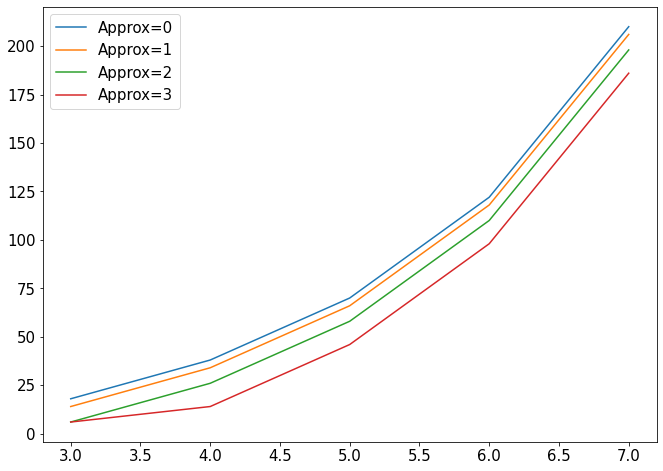

[{3: 18, 4: 38, 5: 70, 6: 122, 7: 210}, {3: 14, 4: 34, 5: 66, 6: 118, 7: 206}, {3: 6, 4: 26, 5: 58, 6: 110, 7: 198}, {3: 6, 4: 14, 5: 46, 6: 98, 7: 186}]


In [10]:
multWalkU0List = multWalkU0(multN,walkGamma,walkTime,cCycle)
multWalkCircQFT = runMultWalkCircQFT(multNCirc,multWalkU0List,walkTime,initStringList,method,simulatorBackend,approxQFTList,True)
multWalkCnot = multCNotCount(multNCirc,multWalkCircQFT)
for approx,result in zip(approxQFTList,multWalkCnot):
    plt.plot(result.keys(),result.values(),label="Approx=%s"%approx)
    plt.legend()
plt.show()
print(multWalkCnot)

#### U3

In [ ]:
multWalkU0List = multWalkU0(multN,walkGamma,walkTime,cCycle)
multWalkCircQFT = runMultWalkCircQFT(multNCirc,multWalkU0List,walkTime,initStringList,method,simulatorBackend,approxQFTList)
multWalkU3 = multU3Count(multNCirc,multWalkCircQFT)
for approx,result in zip(approxQFTList,multWalkU3):
    plt.plot(result.keys(),result.values(),label="Approx=%s"%approx)
    plt.legend()
plt.show()
print(multWalkU3)

### 2.9 - Fidelity: x_axis: N, y_axis: fidelity, and QFT approx

## 3 - Searching Problems


### 3.1 - Clique, N = 8

8.885765876316732


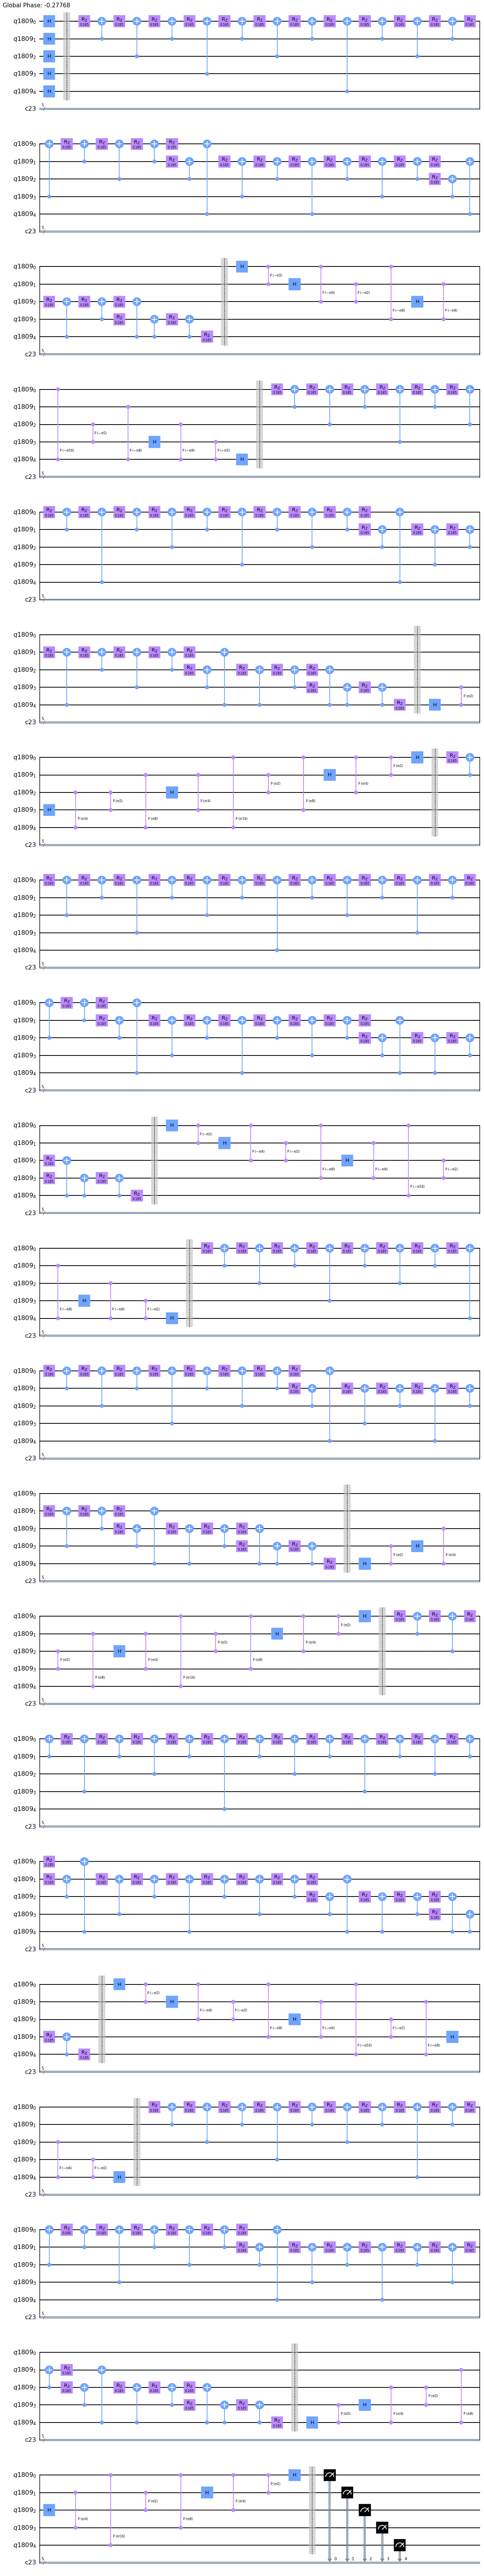

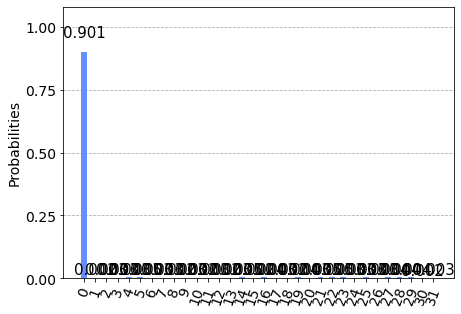

In [36]:
nq = 5
N = 2 ** nq
r = 3
shots = 5000
gamma = 1 / N
t = ((np.pi)/2 * np.sqrt(N))
print(t)
markedList = [0]
approxQFT = 0
cComplete = [0]+[1 for x in range(N-1)]

A = circulant_adjacency(N, cComplete)
O = oracle(N,markedList,t,r)
expD = exp_diag_qft(gamma * A * t / r, N)

searchCirc = contSearchCirc(N,nq,t,r,approxQFT,O,expD)
display(searchCirc.draw(output='mpl'))
searchResults = runWalkResults(searchCirc,shots)
display(plot_histogram(searchResults))